# [E-03] 어제 오른 내 주식, 과연 내일은?

ARIMA를 통해 시계열 데이터를 활용한다. 실제 주식 data를 사용하여 주식의 값을 예측하는 프로젝트이다.
1. 시계열 데이터 준비
2. data를 가져오고 전처리를 수행하기
3. 시계열의 안정성을 분석하기
4. 학습, 태스트 데이터셋 생성하기
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트

ARIMA model은 👆🏻위의 순서 흐름으로 진행이된다.

## 1. Library import 하기

In [1]:
import numpy as np # numpy library
import pandas as pd # pandas
import matplotlib.pyplot as plt # graph를 그리기 위하여 사용된다.
import warnings # 경고를 무시하기위하여 쓰는 library
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller # R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 통계 패키지
from statsmodels.tsa.seasonal import seasonal_decompose #
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf, pacf를 그릴 때 사용됨.
from sklearn.metrics import mean_squared_error, mean_absolute_error # mse, mae 등 모델의 예측값과의 오차를 구하기 위해 사용됨.
import math # rmse 값을 구할 때 sqrt 함수를 사용한다.

## 2. 시계열 데이터 준비

❗️ 시계열이란 시간 순서대로 발생한 데이터의 수열이라는 뜻입니다. 날짜가 인덱스의 역할을 하게됨.

In [2]:
# 주식 정보가 담겨있는 csv file을 index col을 날짜로 줘서 받는다.
df = pd.read_csv('/aiffel/aiffel/stock_prediction/data/035420.KS.csv', index_col='Date', parse_dates=True)

# csv file이 data frame으로 저장되었는지 확인한다.
print(df.head())

# 많은 col 중에서 종가인 Close만 시리즈로 뽑아낸다.
ts = df['Close']
print(ts.head())

                Open      High       Low     Close     Adj Close   Volume
Date                                                                     
2021-04-28  381500.0  382000.0  373000.0  373500.0  373003.62500   485971
2021-04-29  373500.0  377500.0  366000.0  366500.0  366012.90625   743106
2021-04-30  366000.0  366000.0  353500.0  359500.0  359022.21875  1028215
2021-05-03  366000.0  370500.0  360500.0  363000.0  362517.56250   507361
2021-05-04  366000.0  367000.0  360500.0  364500.0  364015.56250   398383
Date
2021-04-28    373500.0
2021-04-29    366500.0
2021-04-30    359500.0
2021-05-03    363000.0
2021-05-04    364500.0
Name: Close, dtype: float64


- 제공된 dataset에는 **Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)**을 컬럼값으로 가지고 있는 data들이 저장되어 있는 것을 확인할 수 있습니다.
이번 프로젝트에서는 우리는 **종가(Close)**만 사용한다.

## 3. 각종 전처리 수행

❗️분석에 들어가기 전에 분석결과에 영향을 줄 수 있는 요소를 없애고 보정하는 작업인 전처리를 수행해야함.
- 결측치 처리
- 로그 변환

In [3]:
# 결측치 처리 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [4]:
# 로그 변환 시도 
ts_log = np.log(ts)

- 결측치(NaN)가 들어있는 경우에는 보간기법으로 채워줌.
- 분산이 일정하지 않은 경우에는 로그 변환을 시도한다.

## 4. 시계열 안정성 분석

❗️ 안정적(Stationary)이다는 것은 시계열 데이터를 만들어내는 시간의 변화에 무관하게 일정한 프로세스가 존재한다는 뜻입니다. 즉 과거의 데이터에 일정한 패턴이 발견되고 미래에도 패턴이 동일하게 반복될 것이라는 전제가 있어야 시계열 데이터로 예측이 가능하다.

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

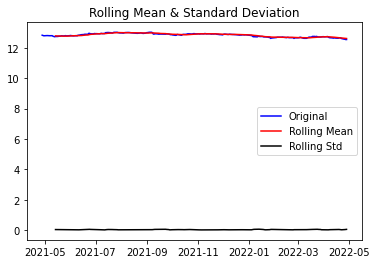

Results of Dickey-Fuller Test:
Test Statistic                  -0.050092
p-value                          0.954188
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [5]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window = 12):
    '''
    정성적 그래프 분석을 위하여 인자로 받은 시계열과 부분집합의 크기로 시계열의 이동평균과 이동표준편차를 구하여
    그래프를 출력해주는 함수이다.
    
    Arguments:
        timeseries: 분석해야할 시계열
        window: 이동평균과 이동표준편차를 구하기 위한 부분 집합의 크기

    return: 없음
    '''
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original') # 원본시계열, 파란색의 Original 라벨    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean') # 이동평균 시계열, 빨간색의 Rolling Mean 라벨
    std = plt.plot(rolstd, color='black', label='Rolling Std') # 이동표준편차 시계열, 검은색의 Rolling std 라벨
    plt.legend(loc='best') # loc = 'best' 옵션을 활용하여 data가 가려지지 않는 최적의 장소에 범례를 보여줌
    plt.title('Rolling Mean & Standard Deviation') # 제목 설정
    plt.show(block=False) # block = False 옵션은 그래프를 그려도 끝나지 않고 다음 코드를 실행햠

#정량적 Augmented Dicky-Fuller Test
def augmented_dickey_fuller_test(timeseries):
    '''
    augmented Dicky-Fuller Test를 활용하여 인자로 받은 시계열의 stationary를 통계적으로 분석하여 출력해준다.
    
    Arguments :
        timeseries: 분석해야할 시계열
    return 없음.
    
    '''
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)



plot_rolling_statistics(ts_log, window=12) # 정성적 그래프 분석을 위하여 시계열을 대입한다.
augmented_dickey_fuller_test(ts_log) # 시계열의 정량적 분석을 한다.

- 그래프만 보았을 때는 평균과 분산이 일정하여 시계열이 안정적으로 보인다.
- 시계열이 안정적이지 않다는 귀무가설은 1에 가깝게 나타났다. 귀무가설을 기각할 수 없게 되었으므로 이 시계열은 안정적이지 않다.

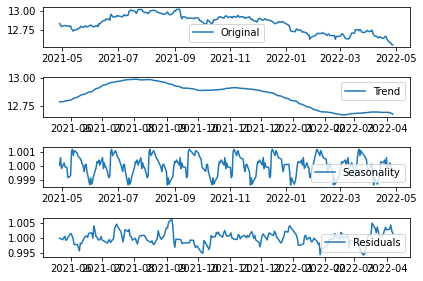

In [6]:
#시계열 분해 (Time Series Decomposition)

# seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Trend:
    - 시간 추이에 따라 나타나는 평균값 변화를 추세
    - moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요
    - 시계열에서 trend를 제거하여서 제거함.
- Seasonality: 
    - Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다.
    - 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화를 잡아줘야함.
    - 패턴을 상쇄하기 위해 효과적인 방법에는 차분
- Residuals:
    - Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual

In [7]:
# Residual 안정성 확인
residual.dropna(inplace=True) # 결측값 제거
augmented_dickey_fuller_test(residual) # 가공한 data dickey_fuller_test에 돌려보기

Results of Dickey-Fuller Test:
Test Statistic                  -5.450816
p-value                          0.000003
#Lags Used                       3.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


- p-value 값이 0에 가까우므로 안정적인 시계열을 얻었다고 볼 수 있다.

## 5. 학습, 테스트 데이터셋 생성

❗️ 시계열 데이터에서 학습 데이터와 테스트 데이터를 분리해 봅시다. 분리 비율은 학습과 테스트에 9:1로 하겠습니다. 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용할 예정입니다.

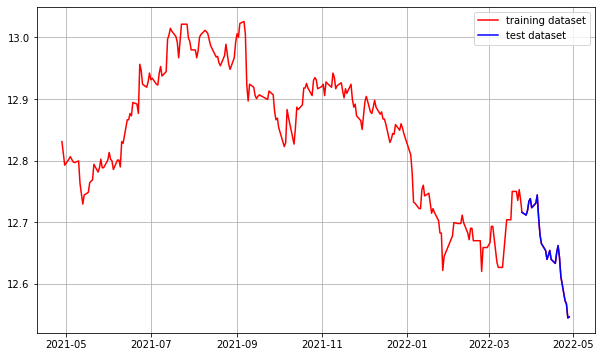

In [8]:
# train, test data를 시간 순서로 9: 1의 비율로 자른다.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True) # plot의 격자무늬를 활성화 시킨다.
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 6. 적정 ARIMA 모수 찾기

❗️ ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정  
p : 자기회귀 모형(AR)의 시차   
d : 차분 누적(I) 횟수   
q : 이동평균 모형(MA)의 시차   
>p + q < 2, p * q = 0 //p 나 q 중 하나는 0, AR이나 MA 중 하나의 경향만 가지기 때문입니다.
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

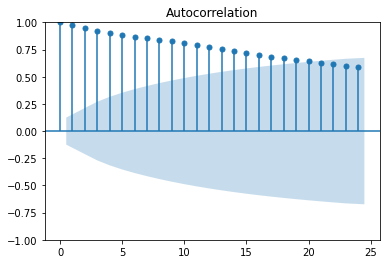

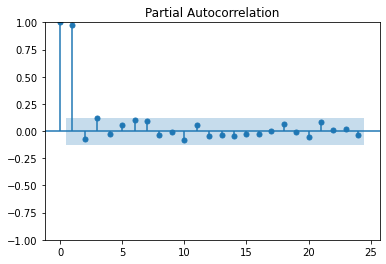

In [9]:
# ACF, PACF 그려보기 -> p,q 구하기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

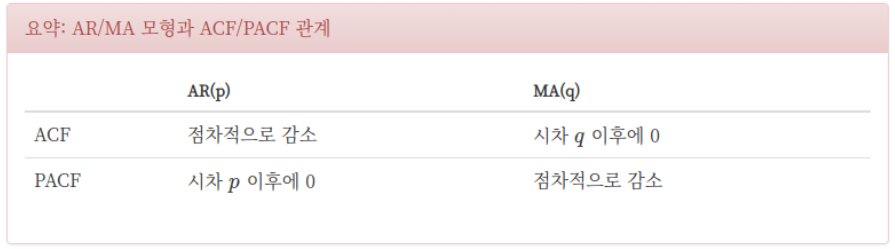

출처:[https://datascienceschool.net]

- 그래프의 모양을 볼 때에 AR모형으로 볼 수 있고 시차 p는 1로 볼 수 있다. p가 1 이상인 구간에서 PACF는 거의 0에 가까워지고 있다. q에 대해서는 적합한 값이 없어 보이니 q는 0으로 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.225825e+01
p-value                        9.204346e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.676447e+00
p-value                        1.544276e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.666267e+00
p-value                        1.312723e-16
#Lags Used                     1.500000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+

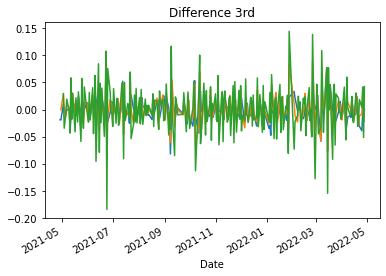

In [10]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

# 3차 차분
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_1)
augmented_dickey_fuller_test(diff_2)
augmented_dickey_fuller_test(diff_3)

- 1차, 2차, 3차 차분을 했을 때 제일 낮은 p-value를 보여준 것은 2차 차분이었다. d = 2로 시도해볼 예정이다.

## 7. ARIMA 모델 훈련과 테스트

❗️시계열 data를 ARIMA 모델에 훈련하고 예측한 값을 test해본다.

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore') # 경고 무시

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 497.407
Date:                Fri, 29 Apr 2022   AIC                           -990.814
Time:                        03:51:44   BIC                           -984.027
Sample:                             0   HQIC                          -988.073
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3951      0.046     -8.681      0.000      -0.484      -0.306
sigma2         0.0006   4.89e-05     13.014      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   5.60   Jarque-

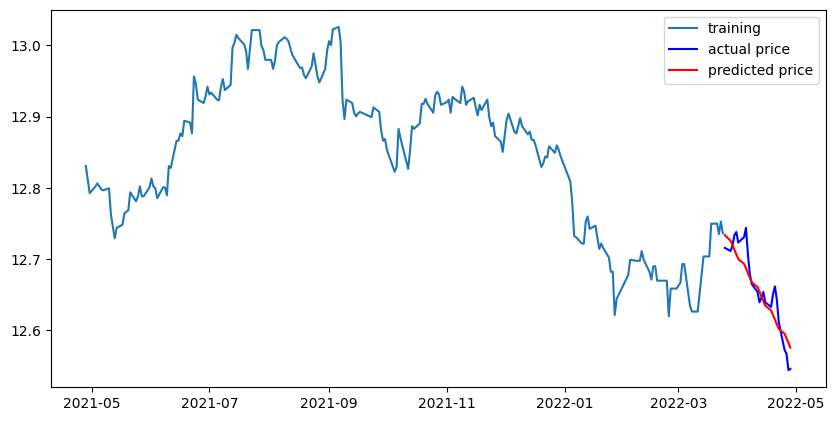

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


- 예측결과와 실제값이 어떻게 진행되는지 그래프를 통하여 확인할 수 있다.

In [13]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  63738180.28913695
MAE:  6478.507571706174
RMSE:  7983.619498018236
MAPE: 2.04%


- 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산을 위해 np.exp()를 통해 전부 원본 스케일로 돌린다.
- MSE, MAE, RMSE, MAPE를 계산하여 오차를 계산한다.

👉🏻 **MAPE 2% 정도로 15% 밈만의 정확도로 예측되었다.**

# 8. APPL & FB 주식 분석해보기

❗️ 앞에 naver의 주식을 단계를 하나씩 짚어보면서 살펴보았다. 위에 있는 코드를 이용하여 2개의 주식 종목도 분석하여 보고 p,q,d 값을 설정하여 오차를 살펴보겠습니다.

## 8-1. APPL

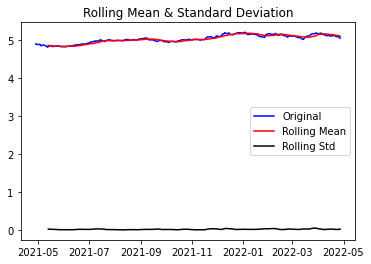

Results of Dickey-Fuller Test:
Test Statistic                  -1.495885
p-value                          0.535546
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [14]:
# 1. 시계열 데이터 준비
# data 시계열 data로 변환하기
dataset_filepath = '/aiffel/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']



# 2. 각종 전처리 수행
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환 시도 
ts_log = np.log(ts)

# 3. 시계열 안정성 분석
# 정상적으로 확인해보기
plot_rolling_statistics(ts_log, window=12)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

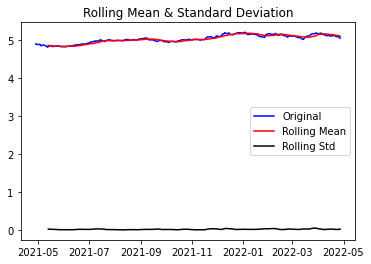

Results of Dickey-Fuller Test:
Test Statistic                  -1.495885
p-value                          0.535546
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.542458
p-value                          0.000165
#Lags Used                       8.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


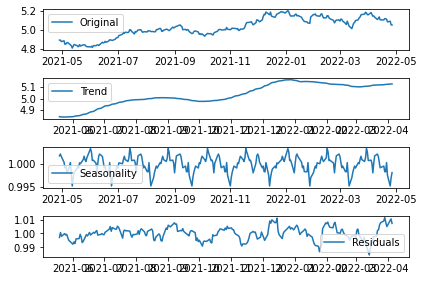

In [15]:
# 3. 시계열 안정성 분석
# 정상적으로 확인해보기
plot_rolling_statistics(ts_log, window=12)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

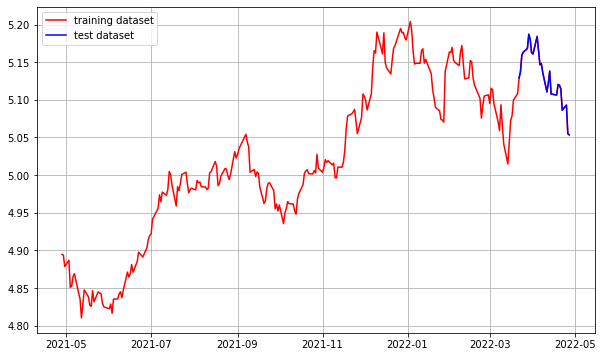

In [16]:
# 4. 학습, 테스트 데이터셋 생성
# train, test data 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

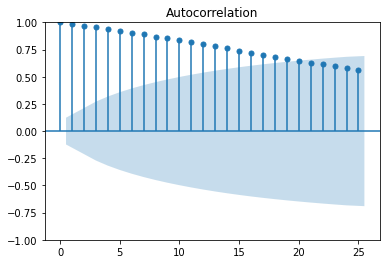

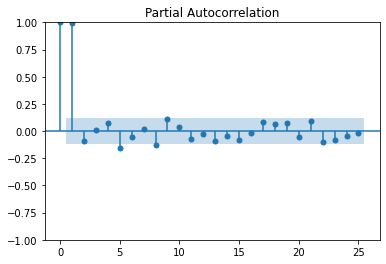


DF Test로 d값을 찾기
Results of Dickey-Fuller Test:
Test Statistic                -1.467357e+01
p-value                        3.238097e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.924173e+00
p-value                        3.656248e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.293850e+00
p-value                        1.160291e-15
#Lags Used                     1.500000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)     

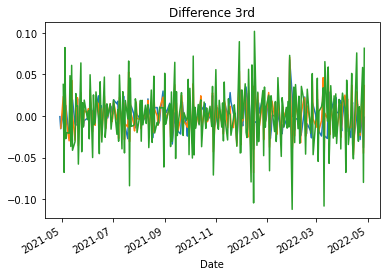

In [17]:
# 5. 적정 ARIMA 모수 찾기
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()
print()
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
# 3차 차분
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')
print("DF Test로 d값을 찾기")
augmented_dickey_fuller_test(diff_1)
augmented_dickey_fuller_test(diff_2)
augmented_dickey_fuller_test(diff_3)

- AR 그래프에서 큰 경사가 나는 것을 보니 AR모형으로 볼 수 있고 큰 시차가 나는 부분은 p는 1로 볼 수 있다. 다른 것도 넣어볼 예정이다.
- q에 대해서는 적합한 값이 없어 보이니 q는 0으로 볼 수 있다. 
- p-value 값은 d = 1 일때 가장 안정적인 즉 가장 작은 값을 보여준다.

In [18]:
#6. ARIMA 모델 훈련과 테스트
def ARM(p,d,q):
    '''
        ar의 시차, 차분 누적 횟수, MA의 시차를 매개변수로 받아 정확도와 plot을 그려준다.
        
        Argument:
            p : 자기회귀 모형(AR)의 시차
            d : 차분 누적(I) 횟수
            q : 이동평균 모형(MA)의 시차
    '''
    # Build and Train  Model
    model = ARIMA(train_data, order=(p,d,q))  
    fitted_m = model.fit() 
    print(fitted_m.summary())
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()

    # 최종 예측 모델 정확도 측정
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 623.684
Date:                Fri, 29 Apr 2022   AIC                          -1243.369
Time:                        03:51:47   BIC                          -1236.528
Sample:                             0   HQIC                         -1240.608
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0843      0.061      1.373      0.170      -0.036       0.205
sigma2         0.0002   1.81e-05     12.988      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

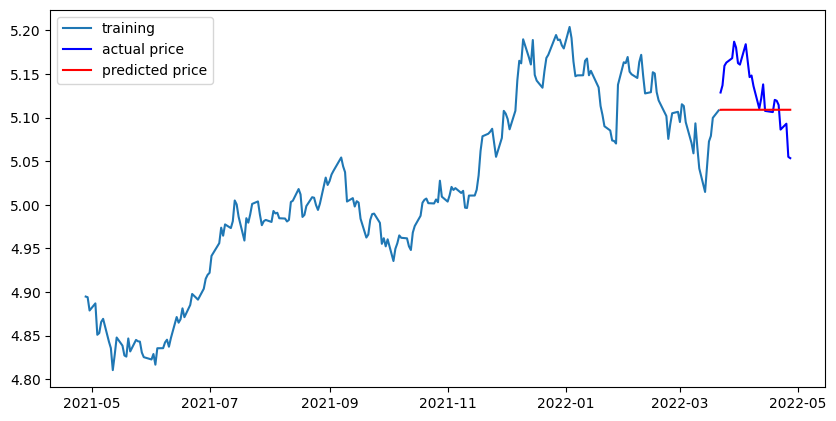

MSE:  52.33094271693739
MAE:  5.99881548025547
RMSE:  7.234012905499782
MAPE: 3.49%


In [19]:
ARM(1,1,0)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(8, 1, 0)   Log Likelihood                 627.828
Date:                Fri, 29 Apr 2022   AIC                          -1237.655
Time:                        03:51:48   BIC                          -1206.870
Sample:                             0   HQIC                         -1225.232
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0887      0.065      1.373      0.170      -0.038       0.215
ar.L2         -0.0649      0.074     -0.874      0.382      -0.211       0.081
ar.L3         -0.0870      0.068     -1.270      0.2

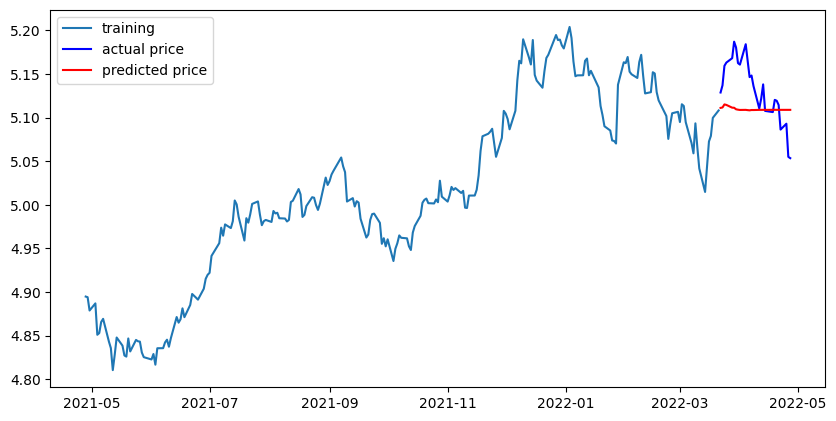

MSE:  50.221474723556895
MAE:  5.871248049261021
RMSE:  7.086711135890675
MAPE: 3.42%


In [20]:
ARM(8, 1, 0)

- **p를 8로 줬을 때 3.42%fh 1로 줬을 때 보다 0.07%가 낮다는 것을 확인할 수 있다.**

## 8-2. FB

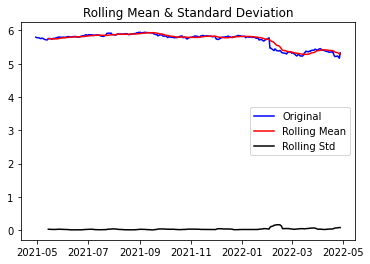

Results of Dickey-Fuller Test:
Test Statistic                  -0.453539
p-value                          0.900769
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [21]:
# 1. 시계열 데이터 준비
# data 시계열 data로 변환하기
dataset_filepath = '/aiffel/aiffel/stock_prediction/data/FB.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

# 2. 각종 전처리 수행
# 결측치 처리
ts = ts.interpolate(method='time')
# 로그 변환 시도 
ts_log = np.log(ts)

# 3. 시계열 안정성 분석
# 정상적으로 확인해보기
plot_rolling_statistics(ts_log, window=12)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -5.058490
p-value                          0.000017
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


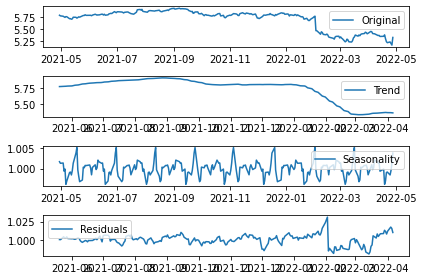

In [22]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

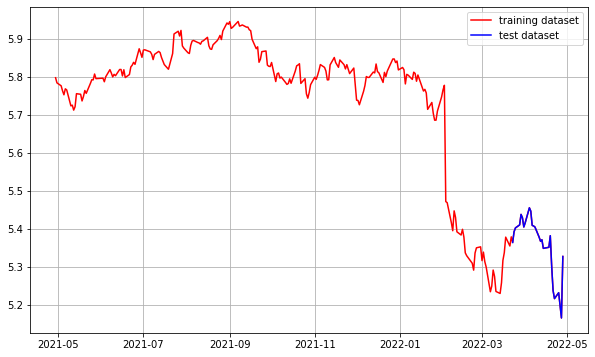

In [23]:
# 4. 학습, 테스트 데이터셋 생성
# train, test data 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

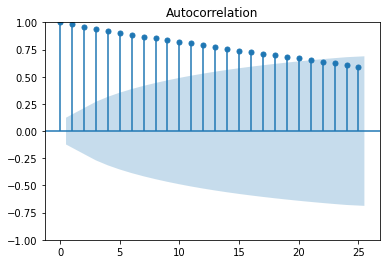

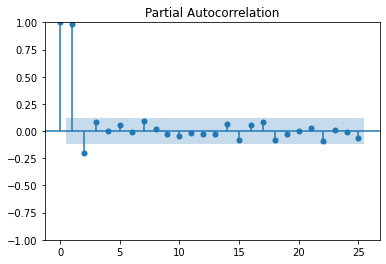


Results of Dickey-Fuller Test:
Test Statistic                -1.515417e+01
p-value                        6.731282e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.517602e+00
p-value                        1.123020e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.966115e+00
p-value                        2.862043e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e

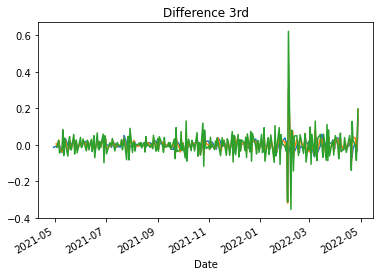

In [24]:
# 5. 적정 ARIMA 모수 찾기
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()
print()
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
# 3차 차분
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')
augmented_dickey_fuller_test(diff_1)
augmented_dickey_fuller_test(diff_2)
augmented_dickey_fuller_test(diff_3)

- AR 그래프에서 큰 경사가 나는 것을 보니 AR모형으로 볼 수 있고 큰 시차가 나는 부분은 p는 1로 볼 수 있다. 다른 것도 넣어볼 예정이다.
- MA 그래프에서 q에 대해서는 적합한 값이 없어 보이니 q는 0으로 볼 수 있다. 
- p-value 값은 d = 1 일때 가장 안정적인 즉 가장 작은 값을 보여준다.

In [25]:
#6. ARIMA 모델 훈련과 테스트
def ARM(p,d,q):
    '''
        ar의 시차, 차분 누적 횟수, MA의 시차를 매개변수로 받아 정확도와 plot을 그려준다.
        
        Argument:
            p : 자기회귀 모형(AR)의 시차
            d : 차분 누적(I) 횟수
            q : 이동평균 모형(MA)의 시차
    '''
    # Build and Train  Model
    model = ARIMA(train_data, order=(p,d,q))  
    fitted_m = model.fit() 
    print(fitted_m.summary())
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()

    # 최종 예측 모델 정확도 측정
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 480.761
Date:                Fri, 29 Apr 2022   AIC                           -957.522
Time:                        03:51:51   BIC                           -950.681
Sample:                             0   HQIC                          -954.761
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0114      0.135     -0.085      0.932      -0.275       0.252
sigma2         0.0008   1.72e-05     48.349      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

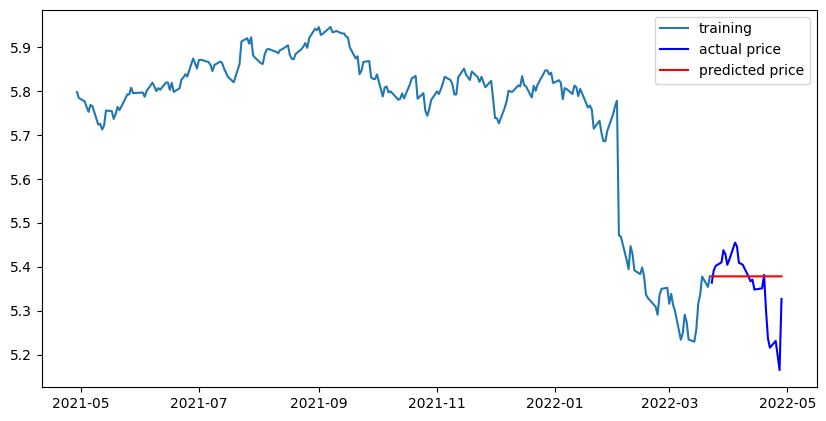

MSE:  283.15264412487636
MAE:  12.319204601230952
RMSE:  16.827140105343997
MAPE: 6.20%


In [26]:
ARM(1, 1, 0)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(17, 1, 0)   Log Likelihood                 489.559
Date:                Fri, 29 Apr 2022   AIC                           -943.117
Time:                        03:51:53   BIC                           -881.547
Sample:                             0   HQIC                          -918.270
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0178      0.148     -0.120      0.904      -0.308       0.272
ar.L2          0.0459      0.070      0.658      0.510      -0.091       0.183
ar.L3         -0.0384      0.080     -0.479      0.6

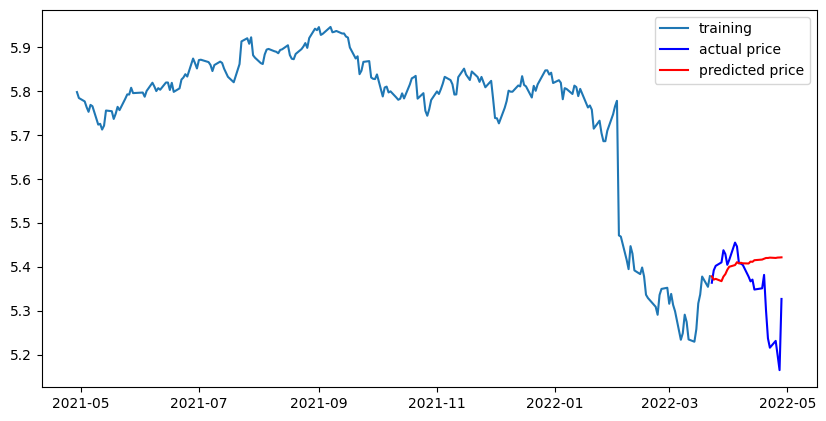

MSE:  452.71798445610995
MAE:  15.276767224886317
RMSE:  21.277170499295952
MAPE: 7.78%


In [27]:
ARM(17,1,0)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 434.862
Date:                Fri, 29 Apr 2022   AIC                           -865.724
Time:                        03:51:54   BIC                           -858.892
Sample:                             0   HQIC                          -862.967
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5244      0.022    -24.050      0.000      -0.567      -0.482
sigma2         0.0012   2.84e-05     43.129      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   5.75   Jarque-

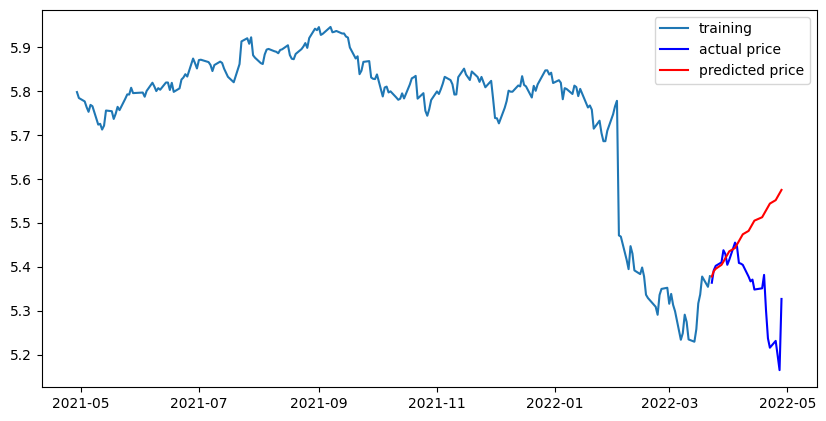

MSE:  1563.6751593477761
MAE:  28.333535595745253
RMSE:  39.54333267881927
MAPE: 14.46%


In [28]:
ARM(1, 2, 0)

- **p를 1로 줬을 때 6.20%로 17로 줬을 때 보다 1.58%가 낮다는 것을 확인할 수 있다.**
- **d가 최적값보다 커졌을 때 오차가 커지는 것을 확인할 수 있다.**

## 9. 회고

- ACF, PACF, AR, MA, 귀무가설, 대립가설 등등 용어가 익숙치 않아서 익히고 이해하는데 시간이 걸렸다. 학부시절에 교수님이 통계학은 Computer와 아주 밀접한 관련이 있다고 하셨는데 왜 그렇게 말씀하셨는지 이제 깨달을 수 있었다. 앞으로도 머신러닝을 배우면서 많은 통계학이 나올텐데 하루빨리 익숙해져야겠다는 생각이 들었던 Chapter였다.
- 그래프와 값을 보면서 p, d, q의 값을 정하는 과정이 이번 Ex에서 제일 재미있었다. 가장 변화가 큰 값, 가장 안정적인 값이 무조건적으로 성공이 아니라 이것저것 다양한 경우의 수를 넣어보면서 값을 수정해야한다.
- 오차가 15퍼센트 미만으로 나왔지만 그래프와 모양은 많이 달랐다. 내가 사용한 모델을 봤을 때 주식에 왜 예측 시스템을 이용하지 않는지 알 수 있었다. 외부적 변수에 의해 시계열 데이터 분석의 전제가 되는 안정성이 훼손될 여지가 많다는 것을 알 수 있었다.
- Ex를 당일에 이해하고 끝내기에는 어렵고 그렇다고 밀리면 따라가기가 벅찬 악순환이 된다. Ex가 있는 날에는 일찍열릴 때 미리 보거나 퍼실님들이 주신 자료가 있다면 꼭 미리 예습을 하고 들어가야겠다.